# 1. Introducción

En este cuaderno realizaremos un análisis y tratamiento de datos de un *dataset* que contiene datos de salud de distintos pacientes: edad, género, altura, peso, colesterol, etc. Con estos datos intentaremos predecir su presión sanguínea alta (columna *ap_hi*). Como veremos, el documento CSV tiene muchas características, pero varias de ellas van a resultar irrelevantes para determinar el valor objetivo en sí, y otras que sí van a ser relevantes tendrán datos incompletos que tendremos que gestionar.

## 1.1. Librerías necesarias

Importaremos en primer lugar las librerías necesarias para nuestro proyecto:

* *NumPy* (alias `np`)
* *Matplotlib* (módulo `pyplot` con alias `plt`)
* *Pandas* (alias `pd`)
* *Seaborn* (alias `sns`)

Además, de la librería `sklearn` incorporaremos algunos módulos que nos van a resultar de utilidad para ciertas tareas puntuales:

* Módulo `mean_squared_error` de `sklearn.metrics`, que usaremos para medir cómo de buenos o malos son los cálculos que haremos
* Módulo `train_test_split` de `sklearn.model_selection` para poder definir conjuntos de entrenamiento y test en nuestros datos
* Clase `DecisionTreeRegressor` de `sklearn.tree` para aplicar un árbol de decisión al final, para hacer una estimación más o menos aproximada de los precios de viviendas.

In [ ]:
# Importar librerías
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

## 1.2. Carga de datos inicial

A continuación, cargaremos los datos del archivo CSV, mostraremos su estructura en pantalla y haremos un primer análisis del dato objetivo (columna *ap_hi*, presión sanguínea alta)

Deberás subir el archivo CSV que se te proporcionará a tu espacio de trabajo en Colab.

In [ ]:
# Cargar datos de CSV en variable "datos"
datos = pd.read_csv('datos_salud2.csv', low_memory=False)
# Guardarnos en una variable "valor_objetivo" el nombre de columna objetivo "ap_hi"
valor_objetivo = 'ap_hi'

In [ ]:
# Mostrar 5 primeras filas
datos.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.0,M,168.0,62.0,110,80,Normal,Normal,No,No,Yes,No
1,1,55.0,F,156.0,85.0,140,90,Well Above Normal,Normal,No,No,Yes,Yes
2,2,51.0,F,165.0,64.0,130,70,Well Above Normal,Normal,No,No,No,Yes
3,3,48.0,M,169.0,82.0,150,100,Normal,Normal,No,No,Yes,Yes
4,4,47.0,F,156.0,56.0,100,60,Normal,Normal,No,No,No,No


In [ ]:
datos.shape

(70000, 13)

In [ ]:
datos[valor_objetivo].describe()

,ap_hi
count,70000.000000
mean,128.815429
std,154.011614
min,-150.000000
25%,120.000000
50%,120.000000
75%,140.000000
max,16020.000000


Como podemos observar, disponemos de 70.000 registros, donde el valor máximo es 16020, y el mínimo es -150, siendo el promedio 128.82 aproximadamente

# 2. Limpieza de datos (*data cleaning*)

En este apartado realizaremos algunos procesos básicos de limpieza de datos sobre el *dataset* de entrada. En concreto veremos si existen columnas que tengan valores faltantes o nulos (*missing values*) y detectaremos también si hay valores anómalos (*outliers*).

## 2.1. Gestión de valores nulos (*missing values*)

Ahora analizaremos qué columnas tienen valores nulos y decidiremos qué hacer con dichos valores.

Comenzaremos obteniendo las estadísticas (porcentajes) de valores nulos en cada columna del *dataset*

In [ ]:
valores_nulos = datos.isnull().sum().sort_values(ascending=False)
# Añadimos "reset_index" para numerar las filas resultantes
ratio_nulos = (valores_nulos / len(datos)).reset_index()
ratio_nulos.columns = ['Caracteristica', 'RatioNulos']
ratio_nulos

,Caracteristica,RatioNulos
0,age,0.000086
1,gender,0.000029
2,cardio,0.000029
3,height,0.000000
4,id,0.000000
5,weight,0.000000
6,ap_hi,0.000000
7,cholesterol,0.000000
8,ap_lo,0.000000
9,gluc,0.000000


Vemos que las columnas con nulos son *age*, *gender* y *cardio*. En general son porcentajes muy bajos de nulos, y podríamos eliminar las filas afectadas con *dropna*, pero vamos a optar por diferentes alternativas

* Reemplazaremos los valores nulos de la edad por la media de la columna
* Reemplazaremos los valores nulos del género por la moda de la columna
* Eliminaremos las filas que tengan el campo *cardio* nulo

In [ ]:
# Reemplazo de edades nulas por la media
datos['age'] = datos['age'].fillna(datos['age'].mean())
# Reemplazo de géneros nulos por la moda
datos['gender'] = datos['gender'].fillna(datos['gender'].mode()[0])
# Eliminación de cardios nulos
datos = datos.dropna(subset=['cardio'])
len(datos)

69998

## 2.2. Tipos de datos

Comenzaremos analizando el tipo de datos de cada columna, y cambiándolo por otro más apropiado si es el caso

In [ ]:
datos.dtypes

,0
id,int64
age,float64
gender,object
height,float64
weight,float64
ap_hi,int64
ap_lo,object
cholesterol,object
gluc,object
smoke,object


Vemos que las columnas numéricas son de 64 bits, cuando en realidad podría ser suficiente con 32. Además, la columna *ap_lo* está tipada como *object*, pero en realidad almacena datos numéricos. La cambiaremos a *int32*.

In [ ]:
datos = datos.astype({'age': 'int32', 'height': 'float32',
  'weight': 'float32', 'ap_hi': 'int32', 'ap_lo': 'int32'})
datos.dtypes

,0
id,int64
age,int32
gender,object
height,float32
weight,float32
ap_hi,int32
ap_lo,int32
cholesterol,object
gluc,object
smoke,object


## 2.3. Gestión de anomalías (*outliers*)

Ahora vamos a comprobar si existen valores anómalos en alguna columna (numérica), y también estableceremos qué hacer en ese caso.

### 2.3.1. Detección visual de anomalías

Comenzaremos analizando en un diagrama de cajas la distribución de valores de las columnas numéricas *age*, *height*, *weight*, *ap_hi* y *ap_lo*.

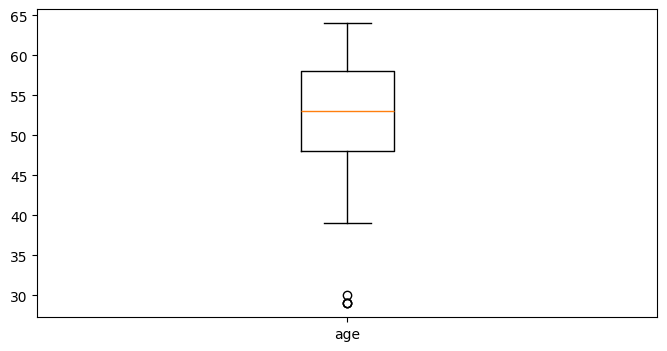

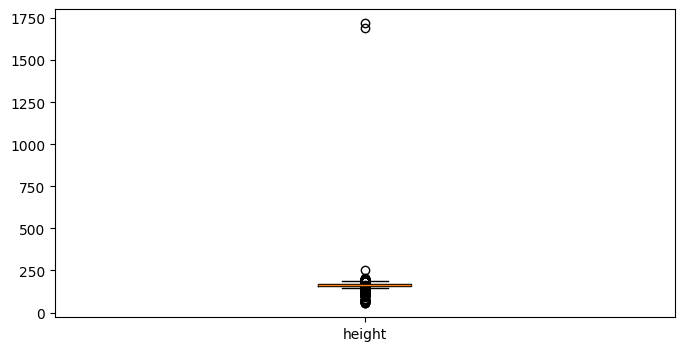

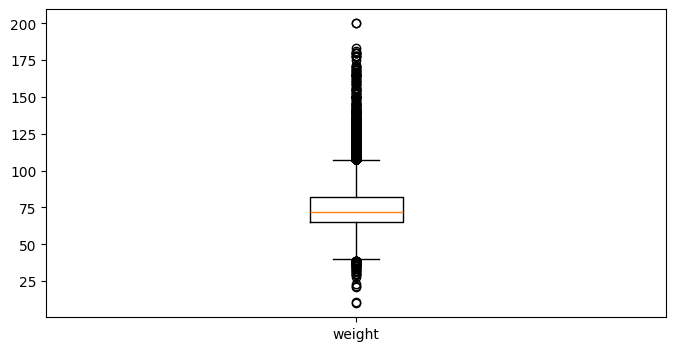

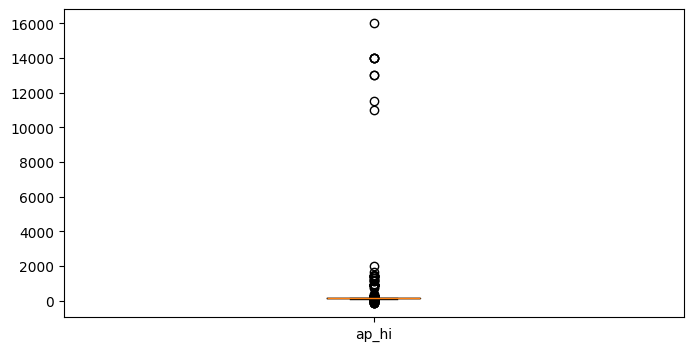

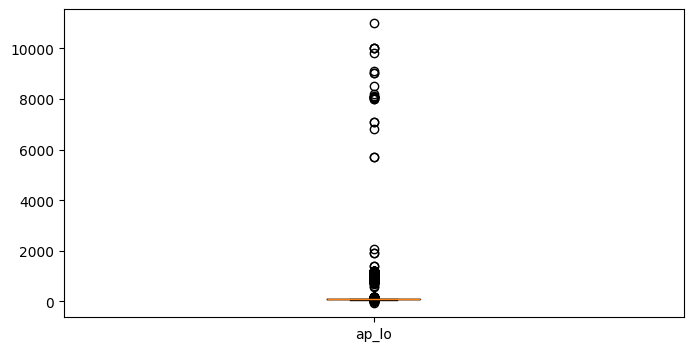

In [ ]:
categorias = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
for var in categorias:
  fig, ax = plt.subplots(figsize=(8, 4))
  plt.boxplot(tick_labels=[var], x=datos[var])

Tomaremos las siguientes decisiones, en vista de los gráficos de caja obtenidos:

* Ignoraremos las anomalías de la edad, ya que corresponden a pacientes jóvenes (en torno a 30 años) pero podemos tenerlos en cuenta.
* Eliminaremos los registros de pacientes con altura superior a 230 cm
* Asignaremos un umbral inferior de 25 kg a todos los pacientes que pesen menos de esa cantidad (ignoraremos las anomalías de exceso de peso, porque pueden ser reales)
* Eliminaremos todas las presiones sanguíneas (*ap_hi* y *ap_lo*) que sean negativas o superiores a una puntuación Z de 2.

In [ ]:
# Eliminar pacientes con altura superior a 230 cm
datos = datos[datos['height'] <= 230]

# Asignar 25 Kg a los pacientes que pesen menos de esa cantidad
datos['weight'] = datos['weight'].apply(
    lambda x: 25 if x < 25 else x
)
# Eliminar presiones sanguíneas negativas
datos = datos[(datos['ap_hi'] >= 0) & (datos['ap_lo'] >= 0)]

# Eliminar presiones sanguíneas superiores a Z = 2
# Paso 1: Obtenemos valores anómalos
media1 = datos['ap_hi'].mean()
media2 = datos['ap_lo'].mean()
desv1 = datos['ap_hi'].std()
desv2 = datos['ap_lo'].std()
outliers1 = []
outliers2 = []
Z = 2
for elemento in datos['ap_hi'].values:
    z = abs(elemento - media1) / desv1
    if z > Z:
        outliers1.append(elemento)
for elemento in datos['ap_lo'].values:
    z = abs(elemento - media2) / desv2
    if z > Z:
        outliers2.append(elemento)
# Paso 2: eliminar filas con outliers
datos = datos[~datos['ap_hi'].isin(outliers1)]
datos = datos[~datos['ap_lo'].isin(outliers2)]

Puedes probar a ejecutar de nuevo los gráficos de caja anteriores para ver el resultado actualizado (NOTA: es posible que si consultas este cuaderno ya relleno, sin ejecutarlo paso a paso, se muestren los gráficos de caja tras haber eliminado anomalías).

Vamos a mostrar ahora el tamaño del dataset (propiedad *shape*) para ver cuántos registros hemos perdido respecto a los 70.000 iniciales.

In [ ]:
datos.shape

(68996, 13)

# 3. Ingeniería de características (*feature engineering*)

En esta etapa nos dedicaremos a tres tareas principalmente:

* Codificar variables categóricas en numéricas
* Seleccionar qué columnas son relevantes para el estudio (*feature selection*)
* Normalizar los datos

## 3.1. Codificación de variables categóricas

Aplicaremos las siguientes transformaciones en las columnas categóricas del estudio:

* La columna *gender* toma los valores *M* (masculino) o *F* (femenino). Crearemos una codificación *one hot* para distinguir con ceros y unos la pertenencia a uno u otro grupo.
* Las columnas *cholesterol* y *gluc* pueden tomar los valores *Normal*, *Above Normal* y *Well Above Normal*. En este caso sí nos interesa que haya una gradación o relación de orden, ya que un nivel de colesterol *Normal* es mejor que uno *Above Normal*, y éste a su vez es mejor que el *Well Above Normal*. Para estas columnas usaremos *label encoding*.
* Las columnas *smoke*, *alco*, *active* y *cardio* tienen valores *Yes/No*, que podemos codificar indistintamente como *one hot* o *label encoding*, ya que el resultado será el mismo (valores 1/0). Nos aseguraremos, en cualquier caso, que el valor *Yes* equivalga a 1 y el *No* a 0.

In [ ]:
# Codificación "one hot" de la columna "gender"
datos = pd.get_dummies(datos, columns=['gender'], prefix='Gender')

# Codificaciones "label encoding" de "cholesterol" y "gluc"
datos['cholesterol'] = datos['cholesterol'].map({'Normal' : 0, 'Above Normal' : 1,
    'Well Above Normal': 2})
datos['gluc'] = datos['gluc'].map({'Normal' : 0, 'Above Normal' : 1,
    'Well Above Normal': 2})

# Codificaciones binarias de columnas SI/NO
datos['smoke'] = datos['smoke'].map({'No': 0, 'Yes': 1})
datos['alco'] = datos['alco'].map({'No': 0, 'Yes': 1})
datos['active'] = datos['active'].map({'No': 0, 'Yes': 1})
datos['cardio'] = datos['cardio'].map({'No': 0, 'Yes': 1})

Podemos probar a mostrar las primeras filas del *dataset* para ver cómo ha cambiado.

In [ ]:
datos.head()

,id,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Gender_F,Gender_M
0,0,50,168.0,62.0,110,80,0,0,0,0,1,0,False,True
1,1,55,156.0,85.0,140,90,2,0,0,0,1,1,True,False
2,2,51,165.0,64.0,130,70,2,0,0,0,0,1,True,False
3,3,48,169.0,82.0,150,100,0,0,0,0,1,1,False,True
4,4,47,156.0,56.0,100,60,0,0,0,0,0,0,True,False


En algunas ocasiones, la codificación *one hot* genera información redundante. En nuestro caso, tenemos ahora dos columnas *Gender_F* y *Gender_M* que nos indican si un paciente es hombre o mujer. Nos bastaría con una de las dos, ya que si no pertenece a un género automáticamente se le asigna el otro. Así que eliminamos, por ejemplo, la columna *Gender_M* del estudio.

In [ ]:
datos.drop('Gender_M', axis=1, inplace=True)

## 3.2. Selección de características (*feature selection*)

Crearemos ahora un mapa de calor de correlación (*correlation heatmap*) usando Pandas y Seaborn para ver las correlaciones o dependencias entre variables.

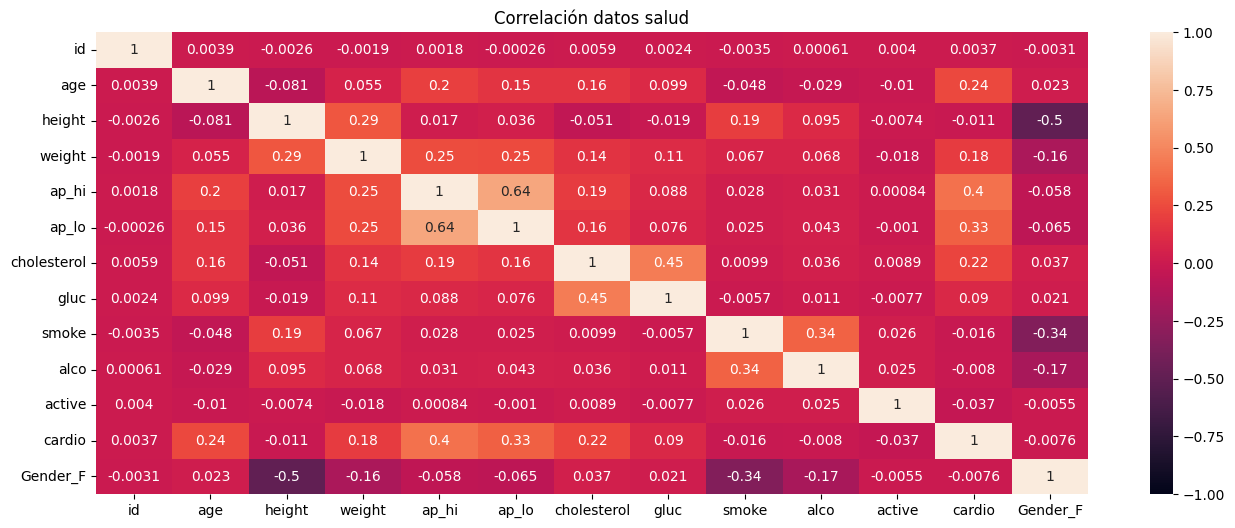

In [ ]:
# Mapa de correlación
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(datos.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlación datos salud')
plt.show()

Vamos a quedarnos con las columnas más relevantes o influyentes en nuestra variable objetivo *ap_hi*.

In [ ]:
columnas_relevantes = ['age', 'weight', 'ap_lo', 'cholesterol', 'cardio']
datos = datos[columnas_relevantes + [valor_objetivo]]
datos.head()

,age,weight,ap_lo,cholesterol,cardio,ap_hi
0,50,62.0,80,0,0,110
1,55,85.0,90,2,1,140
2,51,64.0,70,2,1,130
3,48,82.0,100,0,1,150
4,47,56.0,60,0,0,100


# 4. Análisis exploratorio de datos

Además de los gráficos y cálculos estadísticos que ya hemos venido calculando en pasos anteriores (medias, máximos, mínimos, gráfico de cajas, mapa de calor...) podemos añadir algunos otros gráficos o cálculos para complementar el análisis de los datos con que vamos a trabajar.

A continuación mostramos una matriz de 3 x 2 donde visualizamos el histograma de valores de la columna objetivo, y los gráficos de dispersión de cada uno de los 5 parámetros relevantes respecto a dicho valor objetivo.

Text(0.5, 1.0, 'Distribución de valores de ap_hi')

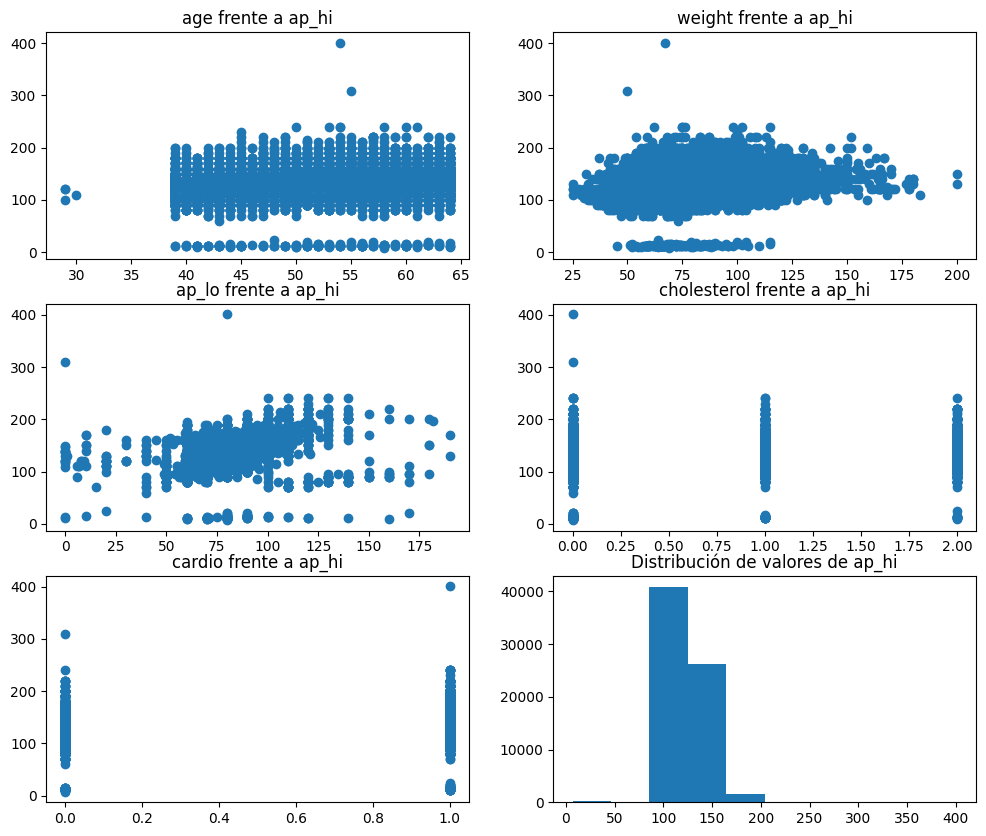

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
for i in range(0, len(columnas_relevantes)):
  fila = i // 2
  columna = i % 2
  ax[fila, columna].scatter(x = datos[columnas_relevantes[i]],
    y = datos[valor_objetivo])
  ax[fila, columna].set_title(columnas_relevantes[i] + " frente a " + valor_objetivo)
ax[2, 1].hist(datos[valor_objetivo], bins=10)
ax[2, 1].set_title("Distribución de valores de " + valor_objetivo)

# 5. Desarrollo de un modelo

Crearemos ahora un árbol de decisión (*decision tree*) sobre el conjunto de datos preparado y evaluaremos su precisión final tras el entrenamiento.

## 5.1. Escalado de características (*feature scaling*)

El escalado de datos es un proceso que no siempre tiene lugar. Pero cuando se van a hacer operaciones matemáticas con los datos (como en este caso, para la operación de regresión) conviene que los datos sean todos de la misma magnitud, y por eso lo aplicamos.

Las columnas codificadas como *one hot* no es necesario escalarlas, puesto que ya están acotadas en un rango 0-1. Las columnas codificadas como *label encoding* podríamos escalarlas si quisiéramos, en el caso de que las etiquetas tuvieran valores más altos. Pero en nuestro caso sólo van del 0 al 2. Así que nos centraremos en la edad, el peso y la presión sanguínea baja. Aplicaremos el escalado por estandarización.

In [ ]:
'''
Método manual

media_edad = datos['age'].mean()
std_edad = datos['age'].std()
media_peso = datos['weight'].mean()
std_peso = datos['weight'].std()
media_ap_lo = datos['ap_lo'].mean()
std_ap_lo = datos['ap_lo'].std()

# Escalamos la edad
datos['age'] = (datos['age'] - media_edad) / std_edad
# Escalamos el peso
datos['weight'] = (datos['weight'] - media_peso) / std_peso
# Escalamos la presión baja
datos['ap_lo'] = (datos['ap_lo'] - media_ap_lo) / std_ap_lo
'''

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
datos[['age', 'weight', 'ap_lo']] = scaler.fit_transform(datos[['age', 'weight', 'ap_lo']])

datos.head(10)

,age,weight,ap_lo,cholesterol,cardio,ap_hi
0,-0.417565,-0.845793,-0.134883,0,0,110
1,0.321089,0.759556,0.877531,2,1,140
2,-0.269834,-0.706198,-1.147298,2,1,130
3,-0.713026,0.550162,1.889945,0,1,150
4,-0.860757,-1.264580,-2.159712,0,0,100
5,1.059742,-0.496805,-0.134883,1,0,120
6,1.059742,1.317938,-0.134883,2,0,130
7,1.207473,1.457534,0.877531,2,1,130
8,-0.713026,-0.217613,-1.147298,0,0,110
9,0.173358,-0.427007,-2.159712,0,0,110


## 5.2. Definición de la métrica

Definimos la función que usaremos para calcular el error cometido en nuestras estimaciones.

In [ ]:
def metrica(valores_reales, valores_predichos):
    return mean_absolute_error(valores_reales, valores_predichos)

## 5.3. Definición de conjuntos de entrenamiento y test

Dividimos en un 20% de datos para test y 80% para entrenamiento, estratificando por la columna ap_lo que es la más relevante para obtener el valor objetivo.

In [ ]:
df_train, df_val = train_test_split(datos, test_size=0.2, random_state=12)

## 5.4. Definición del modelo

Definimos un árbol de decisión simple sobre el dataset anterior y evaluamos resultados.

In [ ]:
modelo_arbol = DecisionTreeRegressor(random_state=12, max_depth=7,
    min_samples_split=10)
modelo_arbol.fit(df_train[columnas_relevantes], df_train[valor_objetivo])
predicciones = modelo_arbol.predict(df_val[columnas_relevantes])
error_val = metrica(df_val[valor_objetivo], predicciones)
print(f'Métrica para datos de validación: {error_val}')

Métrica para datos de validación: 7.619069396815747


### 5.4.1. Prueba del modelo

Vamos a probar ahora el modelo pasándole en un DataFrame los datos de un paciente. Tendremos que escalarlos como hemos hecho en el proceso anterior, y luego llamar a la instrucción `predict` para recoger el resultado

In [ ]:
datos_paciente = pd.DataFrame({'age': [59, 61], 'weight': [56, 95], 'ap_lo': [70, 90], 'cholesterol': [0, 2], 'cardio': [0, 1]})

# Escalamos columnas necesarias
datos_paciente[['age', 'weight', 'ap_lo']] = scaler.transform(datos_paciente[['age', 'weight', 'ap_lo']])

prediccion = modelo_arbol.predict(datos_paciente)
prediccion

array([111.20359281, 141.88376939])